In [1]:
import sys
sys.path.insert(0, '../')
from nn_cno import ode
import numpy as np
import itertools
import jax.numpy as jnp
import jax
import diffrax
import optax

In [2]:
# load the network 
c = ode.NNODE("../nn_cno/datasets/working_case_study/PKN-test.sif",
    "../nn_cno/datasets/working_case_study/MD-test.csv")

WARNING [absl:335]:  No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)
WARNING [absl:335]:  No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)
WARNING [absl:335]:  No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)


In [3]:
c.preprocessing(expansion=False)

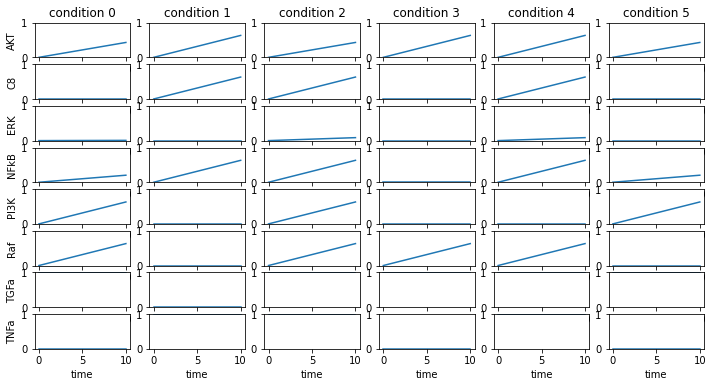

In [5]:
c.plot_simulation(c.simulate())

Vmap for conditions: 

In [6]:
parameters = jnp.array(list(c.get_ODEparameters().values()))
sim_conditions = c.conditions


Checking the gradient calculation through the multi-condition setup

In [7]:
# computes the gradient by central finite difference
# evaluates the loss function at p and measured_data
def cfd_grad_loss(model,p,dp=0.01):
    
    ref = p.copy()

    grad = np.zeros((len(p),))

    for i in range(len(p)):
        p_working_p = np.array(ref)
        p_working_n = np.array(ref)
        p_working_p[i] += dp/2
        p_working_n[i] -= dp/2
        forward = model.loss_function(jnp.array(p_working_p))
        backward = model.loss_function(jnp.array(p_working_n))
        grad[i] = (forward - backward) / (dp)
    return(grad)
    

In [8]:
pars = c.get_ODEparameters()
jax_pars = jnp.asarray(list(pars.values()))
grad = cfd_grad_loss(c,jax_pars)

In [9]:
grad

#cfd_grad_loss(c,pars)

array([-8.36551189e-03, -8.17179680e-03,  1.34404004e-01,  0.00000000e+00,
        0.00000000e+00, -1.69149041e-01,  3.78936529e-03,  3.68356705e-03,
        3.65972519e-03,  3.28272581e-03, -5.45591116e-02, -1.62571669e-03,
       -1.56462193e-03,  0.00000000e+00,  0.00000000e+00,  9.19267535e-02,
        1.49011612e-06,  0.00000000e+00,  1.86592340e-01,  0.00000000e+00,
        0.00000000e+00, -6.85632229e-02])

In [10]:
loss_value, grads = jax.value_and_grad(c.loss_function)(jax_pars)

In [12]:
grads

DeviceArray([-0.0083711 , -0.00817236,  0.13477609,  0.        ,
              0.        , -0.1690298 ,  0.00379114,  0.00368591,
              0.0036613 ,  0.00328223, -0.05461745, -0.00162826,
             -0.00156249,  0.        ,  0.        ,  0.09191454,
              0.        ,  0.        ,  0.18693839,  0.        ,
              0.        , -0.06879918], dtype=float32)

In [13]:
abs(grad- grads) / (abs(grads)+1e-8)

DeviceArray([6.6730386e-04, 6.9059693e-05, 2.7607416e-03, 0.0000000e+00,
             0.0000000e+00, 7.0543232e-04, 4.6932715e-04, 6.3565536e-04,
             4.3045526e-04, 1.5187518e-04, 1.0680527e-03, 1.5636220e-03,
             1.3628581e-03, 0.0000000e+00, 0.0000000e+00, 1.3285711e-04,
             1.4901161e+02, 0.0000000e+00, 1.8511427e-03, 0.0000000e+00,
             0.0000000e+00, 3.4295819e-03], dtype=float32)

In [15]:
c.fit(params=jax_pars)

step 0, loss: 0.15118668973445892


ERROR   [absl:1278]:  Outside call <jax.experimental.host_callback._CallbackWrapper object at 0x17e716e30> threw exception The maximum number of solver steps was reached. Try increasing `max_steps`..
ERROR   [absl:1278]:  Outside call <jax.experimental.host_callback._CallbackWrapper object at 0x17e716e30> threw exception The maximum number of solver steps was reached. Try increasing `max_steps`..
ERROR   [absl:1278]:  Outside call <jax.experimental.host_callback._CallbackWrapper object at 0x17e716e30> threw exception The maximum number of solver steps was reached. Try increasing `max_steps`..


step 10, loss: 0.11698467284440994


XlaRuntimeError: INTERNAL: Generated function failed: RuntimeError: The maximum number of solver steps was reached. Try increasing `max_steps`.

At:
  /Users/gabora/opt/anaconda3/envs/jax_ode/lib/python3.10/site-packages/diffrax/misc/errors.py(33): raises
  /Users/gabora/opt/anaconda3/envs/jax_ode/lib/python3.10/site-packages/jax/experimental/host_callback.py(724): __call__
  /Users/gabora/opt/anaconda3/envs/jax_ode/lib/python3.10/site-packages/jax/experimental/host_callback.py(1296): _outside_call_run_callback
  /Users/gabora/opt/anaconda3/envs/jax_ode/lib/python3.10/site-packages/jax/experimental/host_callback.py(1173): wrapped_callback
  /Users/gabora/opt/anaconda3/envs/jax_ode/lib/python3.10/site-packages/jax/_src/dispatch.py(615): _execute_compiled
  /Users/gabora/opt/anaconda3/envs/jax_ode/lib/python3.10/site-packages/jax/_src/dispatch.py(185): _xla_call_impl
  /Users/gabora/opt/anaconda3/envs/jax_ode/lib/python3.10/site-packages/jax/core.py(678): process_call
  /Users/gabora/opt/anaconda3/envs/jax_ode/lib/python3.10/site-packages/jax/core.py(1781): call_bind
  /Users/gabora/opt/anaconda3/envs/jax_ode/lib/python3.10/site-packages/jax/core.py(1765): bind
  /Users/gabora/opt/anaconda3/envs/jax_ode/lib/python3.10/site-packages/jax/interpreters/partial_eval.py(213): process_call
  /Users/gabora/opt/anaconda3/envs/jax_ode/lib/python3.10/site-packages/jax/core.py(1781): call_bind
  /Users/gabora/opt/anaconda3/envs/jax_ode/lib/python3.10/site-packages/jax/core.py(1765): bind
  /Users/gabora/opt/anaconda3/envs/jax_ode/lib/python3.10/site-packages/jax/interpreters/ad.py(335): process_call
  /Users/gabora/opt/anaconda3/envs/jax_ode/lib/python3.10/site-packages/jax/core.py(1781): call_bind
  /Users/gabora/opt/anaconda3/envs/jax_ode/lib/python3.10/site-packages/jax/core.py(1765): bind
  /Users/gabora/opt/anaconda3/envs/jax_ode/lib/python3.10/site-packages/jax/_src/api.py(473): cache_miss
  /Users/gabora/opt/anaconda3/envs/jax_ode/lib/python3.10/site-packages/jax/_src/traceback_util.py(162): reraise_with_filtered_traceback
  /Users/gabora/opt/anaconda3/envs/jax_ode/lib/python3.10/site-packages/equinox/jit.py(88): _fun_wrapper
  /Users/gabora/opt/anaconda3/envs/jax_ode/lib/python3.10/site-packages/equinox/jit.py(92): __call__
  /Users/gabora/Documents/SaezGroup/LocalGitRepo/NN_cellnopt/NeuralODEs/tests/../nn_cno/ode/nnode.py(328): simulate
  /Users/gabora/Documents/SaezGroup/LocalGitRepo/NN_cellnopt/NeuralODEs/tests/../nn_cno/ode/nnode.py(396): loss
  /Users/gabora/opt/anaconda3/envs/jax_ode/lib/python3.10/site-packages/jax/linear_util.py(168): call_wrapped
  /Users/gabora/opt/anaconda3/envs/jax_ode/lib/python3.10/site-packages/jax/interpreters/partial_eval.py(616): trace_to_jaxpr_nounits
  /Users/gabora/opt/anaconda3/envs/jax_ode/lib/python3.10/site-packages/jax/_src/profiler.py(206): wrapper
  /Users/gabora/opt/anaconda3/envs/jax_ode/lib/python3.10/site-packages/jax/interpreters/ad.py(119): linearize
  /Users/gabora/opt/anaconda3/envs/jax_ode/lib/python3.10/site-packages/jax/interpreters/ad.py(130): vjp
  /Users/gabora/opt/anaconda3/envs/jax_ode/lib/python3.10/site-packages/jax/_src/api.py(2457): _vjp
  /Users/gabora/opt/anaconda3/envs/jax_ode/lib/python3.10/site-packages/jax/_src/api.py(995): value_and_grad_f
  /Users/gabora/opt/anaconda3/envs/jax_ode/lib/python3.10/site-packages/jax/_src/traceback_util.py(162): reraise_with_filtered_traceback
  /Users/gabora/Documents/SaezGroup/LocalGitRepo/NN_cellnopt/NeuralODEs/tests/../nn_cno/ode/nnode.py(376): step
  /Users/gabora/Documents/SaezGroup/LocalGitRepo/NN_cellnopt/NeuralODEs/tests/../nn_cno/ode/nnode.py(382): fit
  /var/folders/cx/9kyr3rt90c974wdygym_lhgh0000gn/T/ipykernel_27007/753841097.py(1): <cell line: 1>
  /Users/gabora/opt/anaconda3/envs/jax_ode/lib/python3.10/site-packages/IPython/core/interactiveshell.py(3398): run_code
  /Users/gabora/opt/anaconda3/envs/jax_ode/lib/python3.10/site-packages/IPython/core/interactiveshell.py(3338): run_ast_nodes
  /Users/gabora/opt/anaconda3/envs/jax_ode/lib/python3.10/site-packages/IPython/core/interactiveshell.py(3135): run_cell_async
  /Users/gabora/opt/anaconda3/envs/jax_ode/lib/python3.10/site-packages/IPython/core/async_helpers.py(129): _pseudo_sync_runner
  /Users/gabora/opt/anaconda3/envs/jax_ode/lib/python3.10/site-packages/IPython/core/interactiveshell.py(2936): _run_cell
  /Users/gabora/opt/anaconda3/envs/jax_ode/lib/python3.10/site-packages/IPython/core/interactiveshell.py(2881): run_cell
  /Users/gabora/opt/anaconda3/envs/jax_ode/lib/python3.10/site-packages/ipykernel/zmqshell.py(528): run_cell
  /Users/gabora/opt/anaconda3/envs/jax_ode/lib/python3.10/site-packages/ipykernel/ipkernel.py(383): do_execute
  /Users/gabora/opt/anaconda3/envs/jax_ode/lib/python3.10/site-packages/ipykernel/kernelbase.py(724): execute_request
  /Users/gabora/opt/anaconda3/envs/jax_ode/lib/python3.10/site-packages/ipykernel/kernelbase.py(400): dispatch_shell
  /Users/gabora/opt/anaconda3/envs/jax_ode/lib/python3.10/site-packages/ipykernel/kernelbase.py(493): process_one
  /Users/gabora/opt/anaconda3/envs/jax_ode/lib/python3.10/site-packages/ipykernel/kernelbase.py(504): dispatch_queue
  /Users/gabora/opt/anaconda3/envs/jax_ode/lib/python3.10/asyncio/events.py(80): _run
  /Users/gabora/opt/anaconda3/envs/jax_ode/lib/python3.10/asyncio/base_events.py(1896): _run_once
  /Users/gabora/opt/anaconda3/envs/jax_ode/lib/python3.10/asyncio/base_events.py(600): run_forever
  /Users/gabora/opt/anaconda3/envs/jax_ode/lib/python3.10/site-packages/tornado/platform/asyncio.py(199): start
  /Users/gabora/opt/anaconda3/envs/jax_ode/lib/python3.10/site-packages/ipykernel/kernelapp.py(712): start
  /Users/gabora/opt/anaconda3/envs/jax_ode/lib/python3.10/site-packages/traitlets/config/application.py(972): launch_instance
  /Users/gabora/opt/anaconda3/envs/jax_ode/lib/python3.10/site-packages/ipykernel_launcher.py(17): <module>
  /Users/gabora/opt/anaconda3/envs/jax_ode/lib/python3.10/runpy.py(86): _run_code
  /Users/gabora/opt/anaconda3/envs/jax_ode/lib/python3.10/runpy.py(196): _run_module_as_main
